In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Input
from keras.models import Model

pd.set_option("display.max_rows", 30)
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 1000)

In [56]:
data = pd.read_csv(r"../Data/raw/creditcard.csv")


In [57]:
data.head()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [58]:
data.drop(["Time"], axis=1, inplace=True)


In [59]:
# scale the amount column
data["Amount"] = StandardScaler().fit_transform(data["Amount"].values.reshape(-1, 1))


In [60]:
x_train, x_test = train_test_split(data, test_size=0.2, random_state=42)

x_train = x_train[x_train.Class == 0]
x_train = x_train.drop(["Class"], axis=1)

y_test = x_test["Class"]
x_test = x_test.drop(["Class"], axis=1)

x_train = x_train.values
x_test = x_test.values


In [61]:
input_dim = x_train.shape[1]
encoding_dim = 14

input_layer = Input(shape=(input_dim,))

encoder = Dense(
    encoding_dim, activation="relu", activity_regularizer=keras.regularizers.l1(10e-5)
)(input_layer)
encoder = Dense(int(encoding_dim / 2), activation="relu")(encoder)

decoder = Dense(int(encoding_dim / 2), activation="tanh")(encoder)
decoder = Dense(input_dim, activation="relu")(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.compile(optimizer="adam", loss="mean_squared_error", metrics=["accuracy"])

In [66]:
checkpointer = ModelCheckpoint(filepath="raw_data-static_model.h5",
                               verbose=0,
                               save_best_only=True)
earlyStop = EarlyStopping(monitor="val_loss", patience=2)
tensorboard = TensorBoard(log_dir='./logs',
                          histogram_freq=0,
                          write_graph=True,
                          write_images=True)

In [67]:
history = autoencoder.fit(x_train, x_train,
                    epochs=50,
                    batch_size=32,
                    shuffle=True,
                    validation_split=0.2,
                    verbose=1,
                    callbacks=[checkpointer, tensorboard, earlyStop]).history

Epoch 1/50
5687/5687 [==============================] - 14s 2ms/step - loss: 0.6917 - accuracy: 0.7443 - val_loss: 0.7056 - val_accuracy: 0.7415
Epoch 2/50
5687/5687 [==============================] - 15s 3ms/step - loss: 0.6917 - accuracy: 0.7435 - val_loss: 0.7055 - val_accuracy: 0.7443
Epoch 3/50
5687/5687 [==============================] - 15s 3ms/step - loss: 0.6915 - accuracy: 0.7443 - val_loss: 0.7061 - val_accuracy: 0.7493
Epoch 4/50
5687/5687 [==============================] - 13s 2ms/step - loss: 0.6915 - accuracy: 0.7449 - val_loss: 0.7060 - val_accuracy: 0.7470


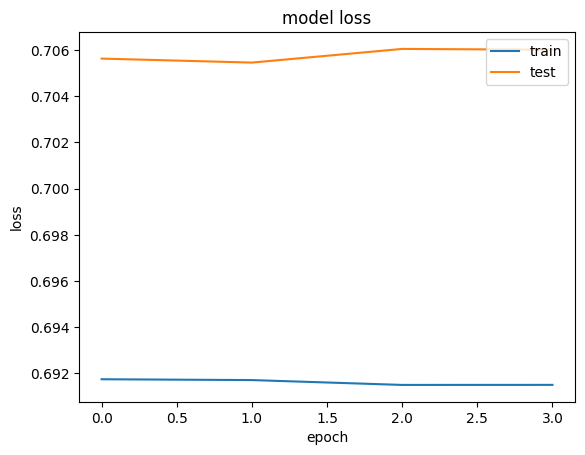

In [68]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right');